![caption](files/iteso.png)

Proyecto Final de Trading

Iteso 

Arturo Ruiz if702462

Juan Carlos Gonzalez if685009

### Objetivo 0(Estrategia)

![caption](files/diagramadeflujo.png)

Bueno lo primero que relizaremos en nuestra estrategia es definir nuestra función a maximizar, la cual será el rendimiento.Luego obtendremos los datos del archivo pasado, ya que es anailisis fundamental de una noticia de Estados Unidos, lo cual ya lo tenemmos. Luego analizaremos los escenarios planteados por el algoritmo de frecuncias a,b,c,d para ver si se compra o se vende cuando sucede ese mismo escenario en otra ocasión. A continuación analizaremos los parámetros a modificar como el volumen de títulos, tamaño de la ventana y momento de realizar la compra, stop loss y take profit,  algo relacionado con el informa propio osea los escenarios. Desúés de tener los parámetros a optimizar, los optimizaremos mediante el PSO, el cual es un enjambre de particulas que busca entre todas las combinaciones el que nos arroje un mejor rendimiento, y con esos parametros haremos pruebas y verifiación para ver que realmente funcione. Guardaremos los resultados de las iteraciones y después las graficaremos en una gráfica de 4 dimensiones con los parámtros para poder entenderlos de forma visual.Luego calcularemos las medidas de atribución al desempeño y obtendremos el drawdown y el balance de la cuenta final para ver si funcionó. Por último observando el desempeño logrado lo trataremos de hacer en tiempo real, para que se haga de forma autónoma.

El concepto matemático para la toma de desición de comprar para hacer tradeing, fué la probabilidad de ocurrencia de un escenario de los 4 obtenidos, pero con dirección positiva, es decir que después de que sucedió el evento hubo un cambio alcista en el tipo de cambio. Ya con estos datos, frecuancias y mejores escenarios, buscamos dentro de todas las combinaciones es decir el espacio de búsqueda cual es la combinación que generara un mayor rendimiento.  



El concepto matemático en el cual nos basaremos para la optimicación de los parámetros a modificar para nuestro algoritmo de compra y venta dependiendo del análisis fundamental previamente visto en el parcial pasado, será utilizar un algoritmos PSO.




### este codigo es el laboratorio 4

In [6]:

#El codigo se inicializa descargando todas las paqueterias de comandos y funciones a utilizar, requerimos pandas,numpy,matplotlib
#y para tener acceso a datos de oanda utilizamos OandaV20.

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime

In [8]:
#Se define una funcion y se configura con los datos que vamos a requerir de oanda
def get_prices(date):
    A1_OA_Da = 16                     # Day Align
    A1_OA_Ta = "America/Mexico_City"  # Time Align
    A1_OA_At = "practice"             # Tipo de cuenta
    A1_OA_In = "USD_MXN"              # Instrumento
    A1_OA_Gn = "M5"                   # Granularidad de velas
    A1_OA_Ak = "ee37e0cfccd3a6d2f842f120aaab81a4-3d14f03cc84eb3fd3fcb14ec3f999fec"
    ##obtener el spot
    ##obtener el precio spot, ponemos la fecha de hoy con un string que es un formato de fecha, definimos 2 momentos antes y despues
    #la timedelta delta es una diferencia entre 2 tiempos, en este caso se dejan 5 minutos para completarse la hora, de esta forma podemos fijar los momentos antes y despues
    #En los parametros (params), ponemos la granularidad, instrumento, zona horaria etc, para acceder a esos datos.
    
    a=datetime.datetime.strptime(date,"%m/%d/%Y %H:%M")
    today = a
    DD = datetime.timedelta(minutes=55)
    earlier = today - DD
    later = today + DD
    F1=later.strftime("%Y-%m-%dT%H:%M:%SZ")
    F2=earlier.strftime("%Y-%m-%dT%H:%M:%SZ")
    api = API(access_token=A1_OA_Ak)
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F2, "to": F1}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    a=list(map(lambda i:[A1_Hist['candles'][i]['time'],float(A1_Hist['candles'][i]['mid']['o']),float(A1_Hist['candles'][i]['mid']['h']),
                          float(A1_Hist['candles'][i]['mid']['l']),float(A1_Hist['candles'][i]['mid']['c'])],range(len(A1_Hist['candles']))))
    pd_hist = pd.DataFrame(a,columns=['TimeStamp','Open','High','Low','Close'])
    pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
    pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
    
    return pd_hist 

In [9]:
#Esta linea sirve para poder leer el archivo 'data'
data=pd.read_csv('data.csv')

In [10]:
#aquí se definen los posibles escenarios de como pudo haber reaccionado el mercado dependiendo de si los datos fueron o no favorable, o positivos.s
a=data.loc[[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus>=data.Previous)]]
b=data.loc[[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus<data.Previous)]]
c=data.loc[[a and b for a,b in zip(data.Actual<data.Consensus,data.Consensus>=data.Previous)]]
d=data.loc[[a and b for a,b in zip(data.Actual<=data.Consensus,data.Consensus<data.Previous)]]
data['a']=[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus>=data.Previous)]
data['b']=[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus<data.Previous)]
data['c']=[a and b for a,b in zip(data.Actual<data.Consensus,data.Consensus>=data.Previous)]
data['d']=[a and b for a,b in zip(data.Actual<=data.Consensus,data.Consensus<data.Previous)]


In [11]:
# direcciones de los movimientos

In [12]:
week_days=list(map(lambda x:datetime.datetime.weekday(datetime.datetime.strptime(data.DateTime[x],"%m/%d/%Y %H:%M")),range(len(data))))

In [13]:
# Aquí se definen 4 indicadores, la dirección del mercado, la volatilidad, el Drawdown o la perdida más severa,
#así como la mejor ganancia, y en temp se almacenan los precios

In [14]:
temp=list(map(lambda x:get_prices(data.DateTime[x]),range(len(data))))

In [15]:
c1_direction=list(map(lambda x:temp[x].loc[21].Close-temp[x].loc[11].Open,range(len(temp))))

In [16]:
c2_vol=list(map(lambda x:max(temp[x].High)-min(temp[x].Low),range(len(temp))))

In [17]:
c3_drawDown=list(map(lambda x:temp[x].loc[0].Open-temp[x].loc[21].Low,range(len(temp))))

In [18]:
c4_drawUp=list(map(lambda x:temp[x].loc[0].Open-temp[x].loc[21].High,range(len(temp))))

In [19]:
#direcciones  que se almacenan en variables

In [20]:
data['c1_direction']=c1_direction
data['c2_vol']=c2_vol
data['c3_drawDown']=c3_drawDown
data['c4_drawUp']=c4_drawUp


In [21]:

#Aqui dividimos la ocurrencia de cada evento dentro del total de eventos para sacar el porcentaje de probabilidad de ocurrencia
#de cada evento.
#frecuancia de cada escenario

In [22]:
po=[sum(data['a'])/len(data),
sum(data['b'])/len(data),
sum(data['c'])/len(data),
sum(data['d'])/len(data)]


In [23]:
#aqui se dividen las direcciones entre el total de veces que ocurrió cada escenario.
tp=np.array([sum(data.loc[a.index]['c1_direction']>0)/sum(data['a']),
sum(data.loc[b.index]['c1_direction']>0)/sum(data['b']),
sum(data.loc[c.index]['c1_direction']>0)/sum(data['c']),
sum(data.loc[d.index]['c1_direction']>0)/sum(data['d'])])

In [24]:
# tp la direcciónes postivas y el complemento tn las direcciones negativas
tn=1-tp

In [25]:
#los 4 escenarios finales

results=np.transpose(pd.DataFrame([tp,tn,po],columns=['a','b','c','d'],index=['direccion positiva','direccion negativa','porcentaje ocurrencia']))

In [26]:
#hacemos un data frame para exponer los resultados

In [27]:
results

,direccion positiva,direccion negativa,porcentaje ocurrencia
a,0.428571,0.571429,0.205882
b,0.000000,1.000000,0.029412
c,0.450000,0.550000,0.588235
d,0.500000,0.500000,0.176471


Los parámetros a optimizar son: take profit, stop loss, la ventana de tiempo para hacer la compra, la cantidad de títulos más optima es realizar la compra y venta con el total de titulos posibles, y el numero de eventos que se utilizaran a c  d, o solamente 1 o 2 o 3 de los antes mencioonados, ya que son los que tienen una dirección positiva.

### Objetivo 1(Optimización)

#### identificación de parámetros

In [28]:
# En esta parte del codigo se definen cuales van a ser los criterios con que se va a abrir cada operación
# y se tiene todos los parámetros para llamar a optimizar más adelante dentro de una función.
def trading(x):
    stop_loss,take_profit,momento_compra,n_eventos=int(x[0]),int(x[1]),int(x[2]),int(x[3])
    total=10000 
    trade=[]
    # En este for recorre todos los eventos y checa en que estado estan a,b,c o d.
    for i in range(len(temp)):
        if (results.loc[data.iloc[i,7:11]]['direccion positiva']<=n_eventos)[0] and (results.loc[data.iloc[i,7:11]]['direccion positiva']>0)[0]:
#Aqui se especifica el monto en dólares para comprar cierto numero de títulos
            dolares_totales=np.trunc(total/temp[i].loc[0].Open)
            monto_compra=dolares_totales*temp[i].loc[momento_compra].Open
            total-=monto_compra

            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000):
                stop_loss_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000)[0][0]+momento_compra+1
                stop_loss_profit=dolares_totales*temp[i].loc[stop_loss_position].Close
            else:
                stop_loss_position=None
            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000):
                take_profit_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000)[0][0]+momento_compra+1
                take_profit_profit=dolares_totales*temp[i].loc[take_profit_position].Close
            else:
                take_profit_position=None

# En esta parte se evalua la parte de arriba, si sucedió el stop loss o take profit y en cual de los 4 casos posibles es el que sucedió.
        

            if not stop_loss_position==None and take_profit_position==None:
                monto_venta=stop_loss_profit
            elif not take_profit_position==None and stop_loss_position==None:
                monto_venta=take_profit_profit
            elif not take_profit_position==None and not stop_loss_position==None:
                if take_profit_position<stop_loss_position:
                    monto_venta=take_profit_profit
                else:
                    monto_venta=stop_loss_profit
            else:
                monto_venta=dolares_totales*temp[i].loc[21].Close


            pL=monto_venta-monto_compra
            total+=monto_venta
            trade.append([dolares_totales,pL,total])

        else:
            trade.append([0,0,total])
            # esto nos devuelve una lista de como se realizaron todos los trades de la cuenta y el balance final de esta
    
    trades=pd.DataFrame(trade,columns=['total quantity','P&L','Total'])
    return -trades.iloc[-1]['Total']
# la función te regresa el total de lo que se generó en la cuenta ya con los parámetros seleccionados.

In [29]:
# en esta parte comienza la optimización de los parámetros, pero al usar esta libreria no se puede guardar el histórico de como encuantra la solución, por eso abajo usamos el PSO.
#import scipy
#from scipy.optimize import Bounds
#from scipy.optimize import minimize
#
#x0=np.array([1.0,1.0,11.0,1.0])
#bounds = Bounds([0.0,0.0,1.0,0.0], [1000.0,1000.0,20.0,1.0])
#res=minimize(trading,x0,method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#te devuelve un resultado óptimo

#### El espacio de búsqueda de todas las combinaciones

In [30]:

# Este es el código del PSO en el cual se recupera información, guarda el óptimo y el historial
#Aquí se cargan librerias y se define la funcion, se declara la posición, velocidad de la particula, error etc.
#la función inicia en Self y x0.
#Tambien se definen todas las acciones de el Pso como se explican en arriba de cada acción más adelante, para luego realizar
#la optimización por medio del Pso.
from __future__ import division
import random
import math
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # posición de la particula
        self.velocity_i=[]          # su velocidad
        self.pos_best_i=[]          # mejor posición individual
        self.err_best_i=-1          # mejor error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evalua el entrenamiento
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # revisa si la situación actual es una posicion individual mejor
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # actualiza la velocidad de la particula
    def update_velocity(self,pos_best_g):
        w=0.5       # peso, la inercia de la particula
        c1=10        # peso a que tan rapido se mueve la particula
        c2=20       

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # actualiza la nueva posición de las particulas
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # ajusta a la máxima posición si es necesario
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # ajusta a la mínima posición si se necesita
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions
        self.dataframe=list(np.zeros(maxiter))
        self.evaluations=list(np.zeros(maxiter))

        num_dimensions=len(x0)
        err_best_g=-1                   # mejor error del grupo
        pos_best_g=[]                   # mejor posición del grupo

        # se establece el enjambre
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # comienza el ciclo de optimización
        i=0
        while i < maxiter:
            
            # ciclo y aprendisaje de las particulas
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determina si la particula actual es la mejor globalmente
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # actualiza las velocidades y posiciones del enjambre

            list(map(lambda j:swarm[j].update_velocity(pos_best_g),range(num_particles)))
            list(map(lambda j:swarm[j].update_position(bounds),range(num_particles)))
            self.dataframe[i]=pd.DataFrame(list(map(lambda x:x.position_i,swarm)))
            self.evaluations[i]=pd.DataFrame(list(map(lambda x:x.err_best_i,swarm)))
            i+=1
            print(i)
        
        # imprime resultados
        print('FINAL:')
        self.values=[list(map(lambda x:int(x),pos_best_g)),err_best_g,swarm]
    def values(self):
        return self.values

#### Método descrito de optimización

El principio matemático de estos algoritmos de inteligencia artificial para la optimización de problemas, se basa en ir aprendiendo a través del tiempo o también llamadoas generaciones iteraciones, en el caso del enjambre de partículas se basa en la exploración de la solución más optima por muchos elementos llamados partículas, las cuales exploran de manera rápida varias posibilidades hasta encontrar con la solución o el punto más optimo del problema, en este caso los parámetros a optimizar.

Con esto se puede obtener de una manera más rápida y precisa una solución entre todo el espacio de búsqueda de nuestro problema con analisis fundamental, ya que cuenta con muchísimas combinaciones y tamaños de pasos, lo cual dificulta ver de manera simple la mejor combinación para que el algoritmo tome la mejor desicion y esto nos genere mayores rendimientos.

In [31]:
#las condiciones

x0=np.array([1.0,1.0,11.0,1.0])
bounds=[(1,1000),(1,1000),(1,20),(0,1)]
# son las iteraciones y si llega a una convergencia aunque usamos pocas iteraciones para que no tardara demasiado en correr.
#utilizamos solo 30 iteraciones y graficamos los resultados de las evaluaciones como una colección de puntos.
res=PSO(trading,x0,bounds,num_particles=10,maxiter=30)
#lo almacena los valores en res

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
FINAL:


#### Visualización de los resultados gráfica 4d y convergencia a la solución

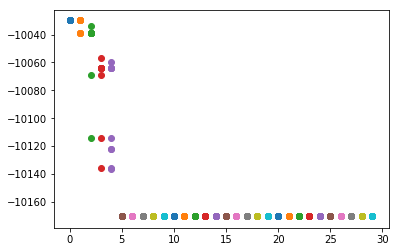

In [32]:
# son las iteraciones y no llega a una convergencia porque usamos pocas iteraciones para que no tardara demasiado en correr.
list(map(lambda x,y:plt.scatter(np.ones(len(x))*y,x),res.evaluations,range(len(res.evaluations))))

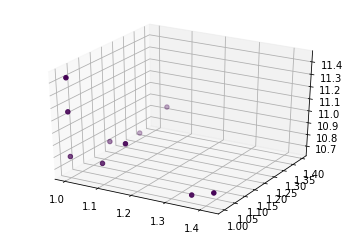

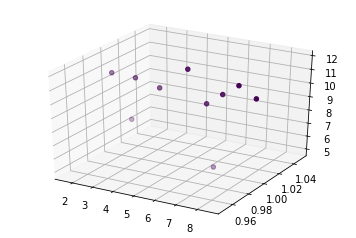

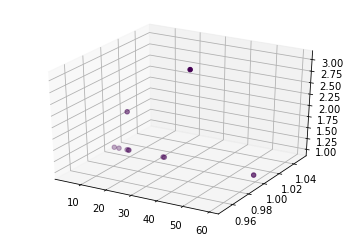

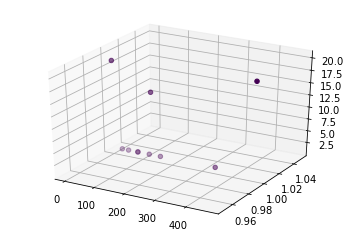

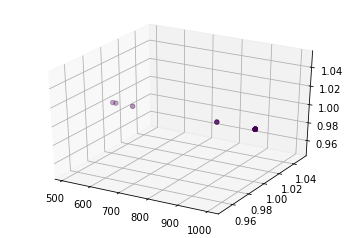

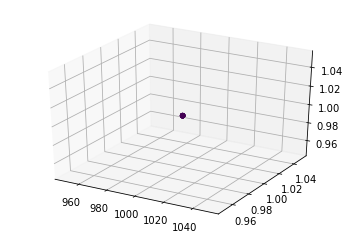

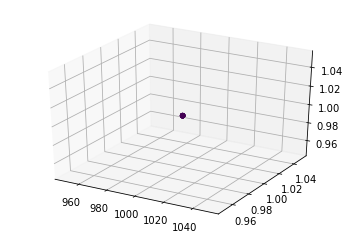

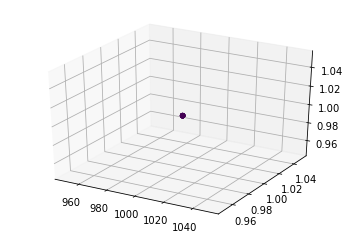

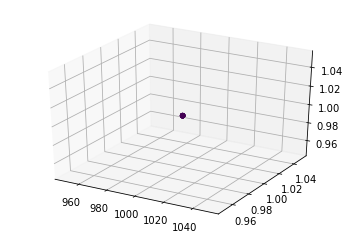

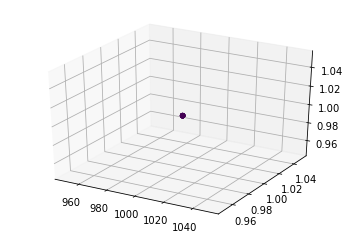

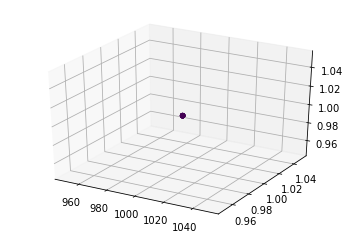

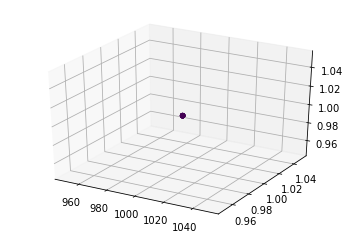

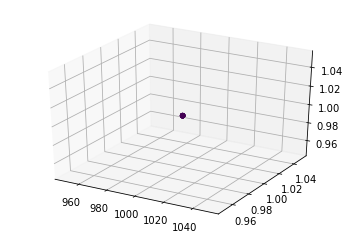

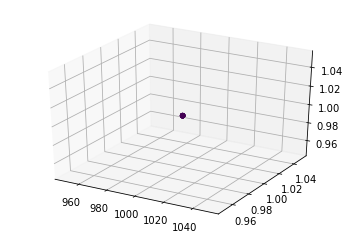

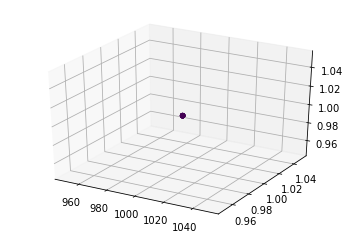

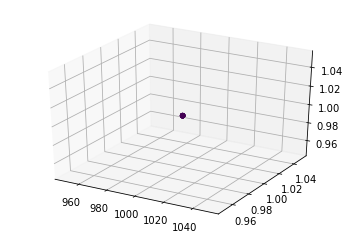

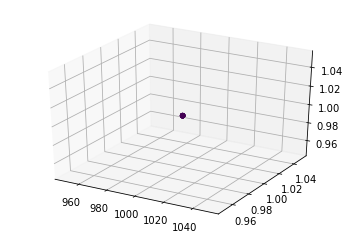

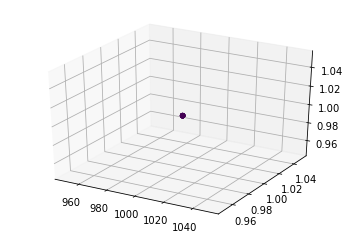

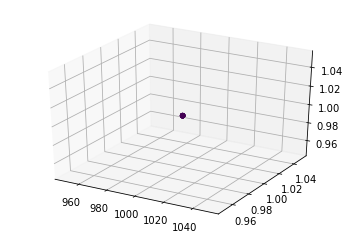

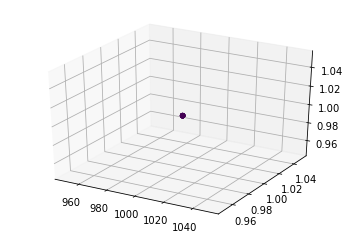

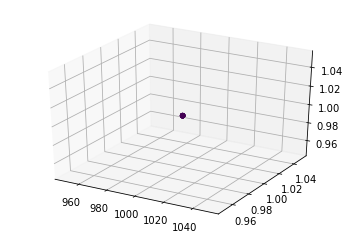

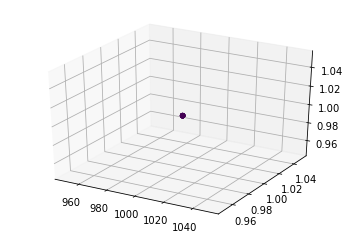

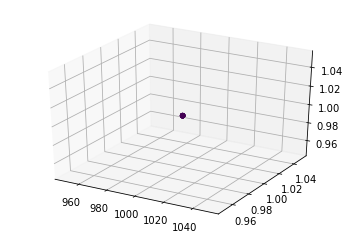

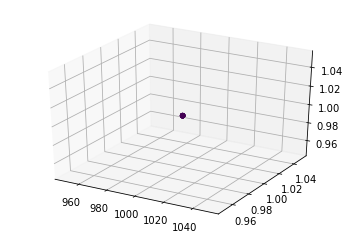

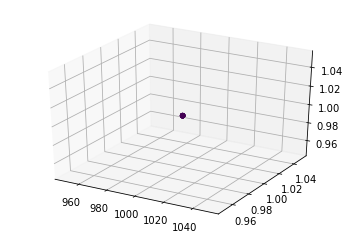

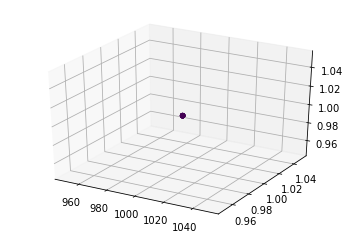

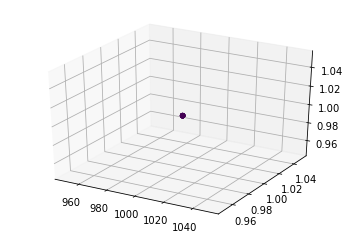

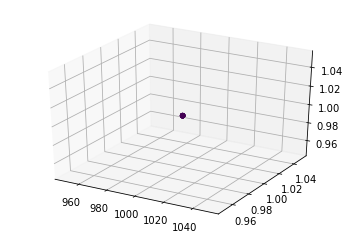

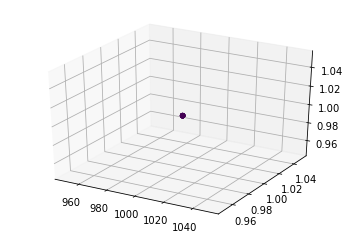

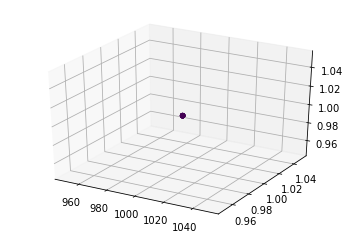

In [34]:
# se importan librerias necesarias para graficar en 3d y meterle la 4 variable representado por la intensidad del color
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
# Creamos la figura

#Graficamos los 30 resultados  en un plano de 3 dimensiones espaciales y 1 categorica
for i in range(len(res.dataframe)):
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(res.dataframe[i][0], res.dataframe[i][1], res.dataframe[i][2], c=res.dataframe[i][3].apply(lambda x:.5 if x>=.5 else .45 if x>=.45 else .42), marker='o')
    plt.show()


In [35]:
# esta función es igual a la anterioir pero al final en lugar de regresarte el ultimo resultado de regresa todo el histórico de los trades.
def trading(x):
    stop_loss,take_profit,momento_compra,n_eventos=int(x[0]),int(x[1]),int(x[2]),int(x[3])
    total=10000 
    trade=[]
    for i in range(len(temp)):
        if (results.loc[data.iloc[i,7:11]]['direccion positiva']<=n_eventos)[0] and (results.loc[data.iloc[i,7:11]]['direccion positiva']>0)[0]:

            dolares_totales=np.trunc(total/temp[i].loc[0].Open)
            monto_compra=dolares_totales*temp[i].loc[momento_compra].Open
            total-=monto_compra

            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000):
                stop_loss_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000)[0][0]+momento_compra+1
                stop_loss_profit=dolares_totales*temp[i].loc[stop_loss_position].Close
            else:
                stop_loss_position=None
            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000):
                take_profit_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000)[0][0]+momento_compra+1
                take_profit_profit=dolares_totales*temp[i].loc[take_profit_position].Close
            else:
                take_profit_position=None



            if not stop_loss_position==None and take_profit_position==None:
                monto_venta=stop_loss_profit
            elif not take_profit_position==None and stop_loss_position==None:
                monto_venta=take_profit_profit
            elif not take_profit_position==None and not stop_loss_position==None:
                if take_profit_position<stop_loss_position:
                    monto_venta=take_profit_profit
                else:
                    monto_venta=stop_loss_profit
            else:
                monto_venta=dolares_totales*temp[i].loc[21].Close


            pL=monto_venta-monto_compra
            total+=monto_venta
            trade.append([dolares_totales,pL,total])

        else:
            trade.append([0,0,total])
    
    trades=pd.DataFrame(trade,columns=['total quantity','P&L','Total'])
    return trades#.iloc[-1]['Total']
#con esto te regresa todos los trades operaciones almacenados. 

### Objetivo 2 (Visualización)

In [36]:
#contiene los trades generados en la función
trades=trading(res.values[0])

In [37]:
#se obtienen los precios de compra
precios_compras=(-trades['P&L']+trades['Total'])/trades['total quantity']

#### precio vs operaciones realizadas, no pudimos juntar todas las gráficas por eso es 1 por cada iteración, y la x muestra el momento de la compra en lugar de la linea horizontal.

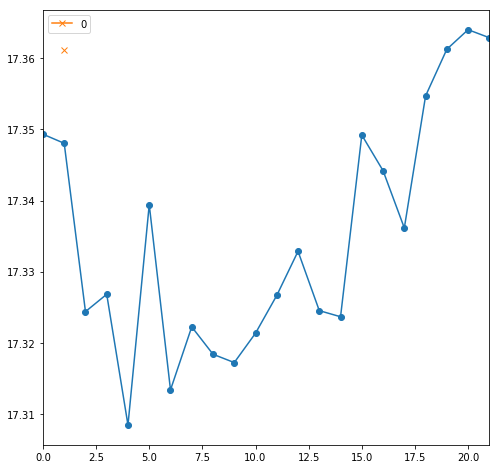

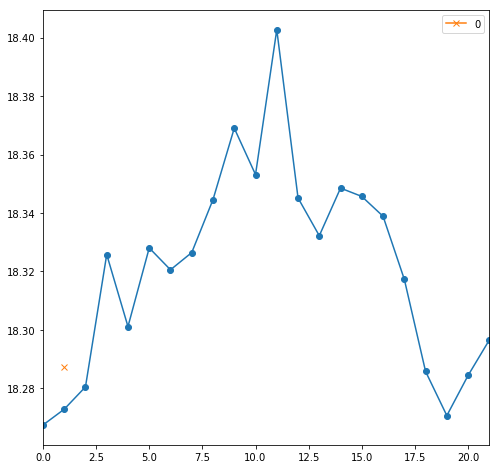

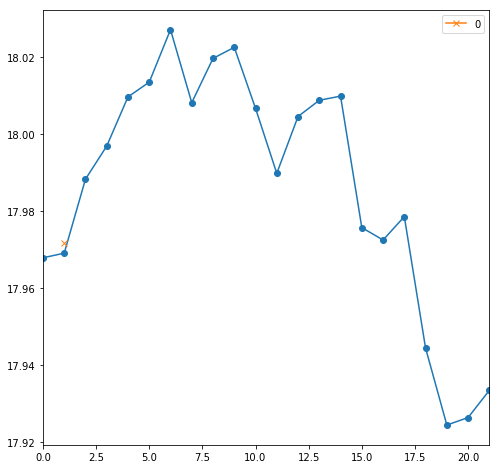

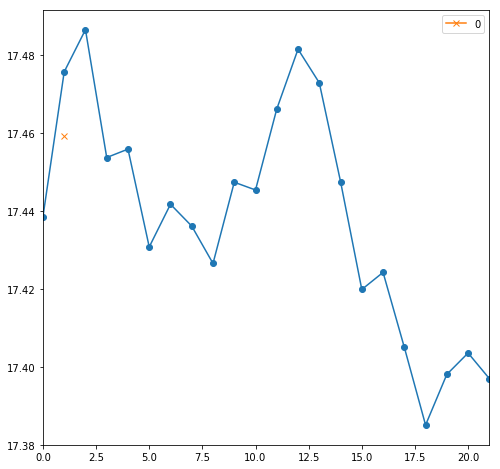

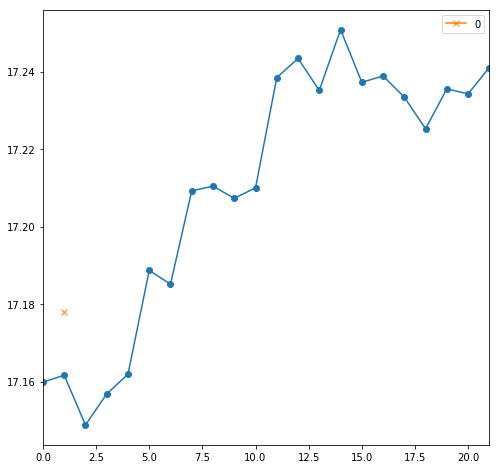

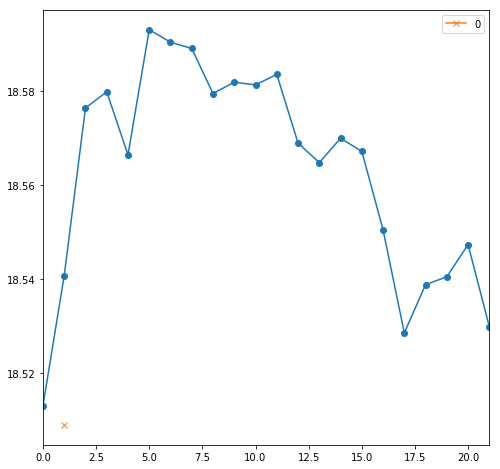

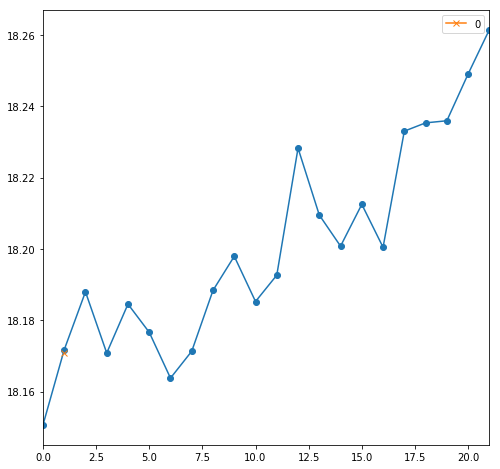

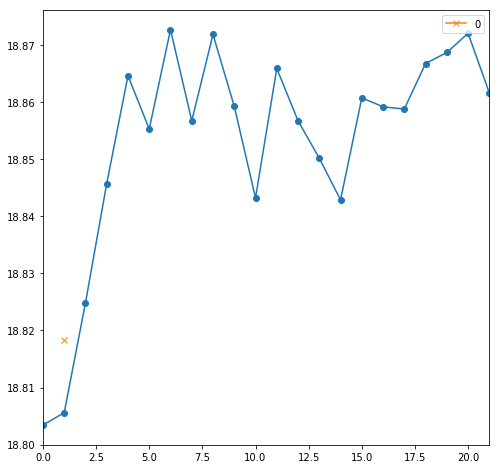

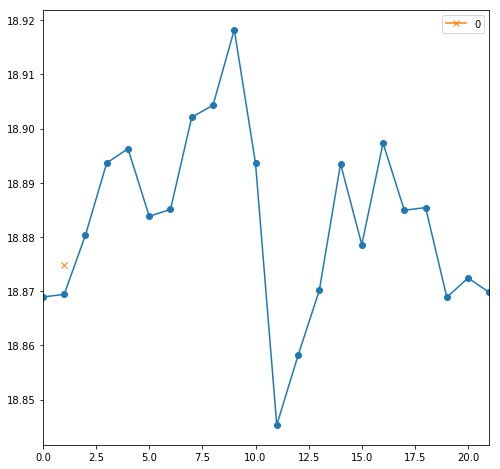

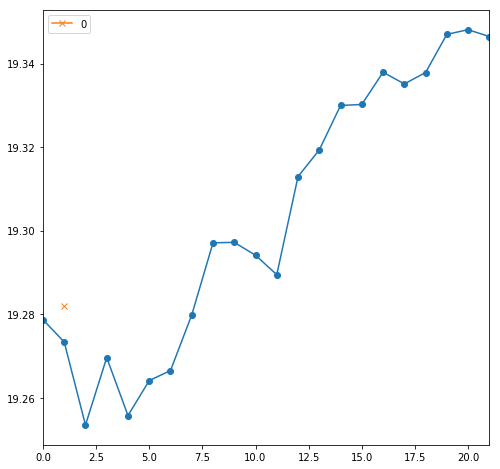

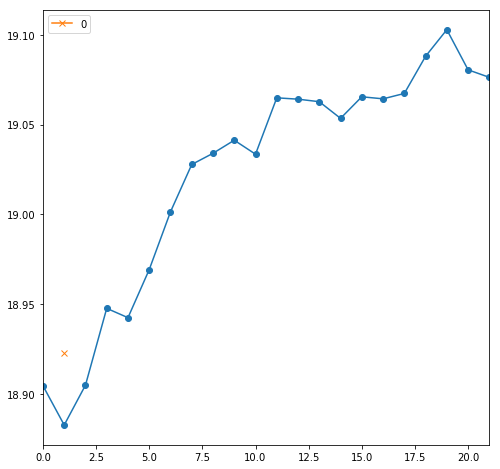

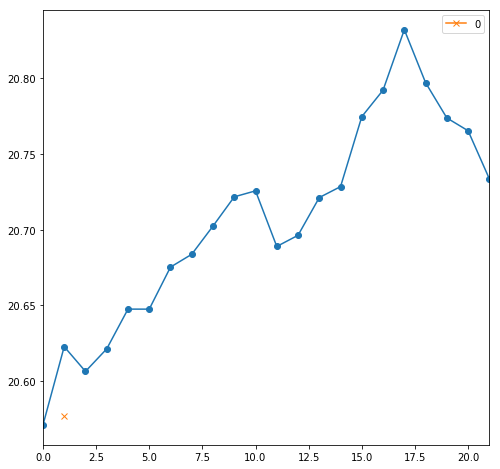

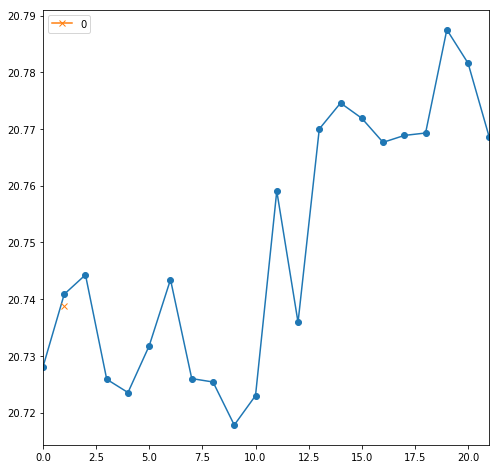

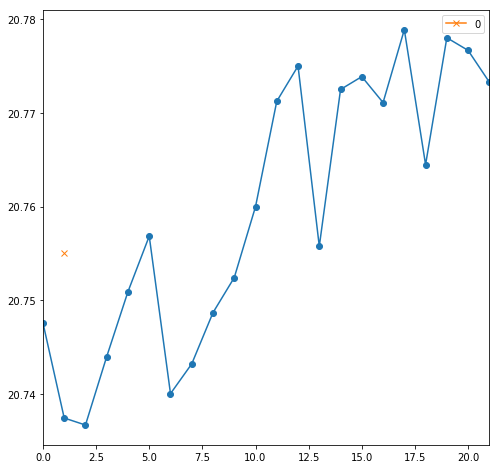

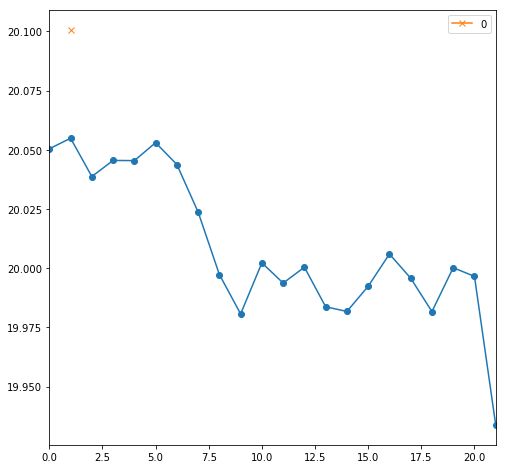

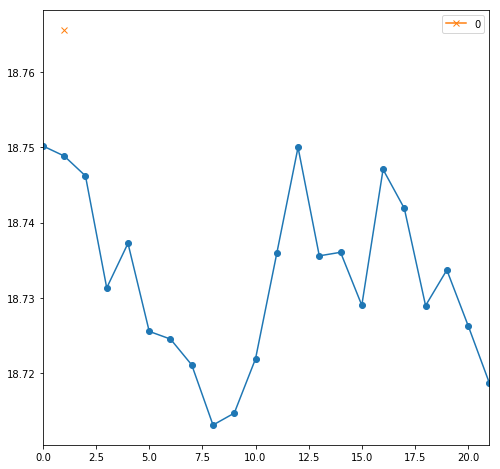

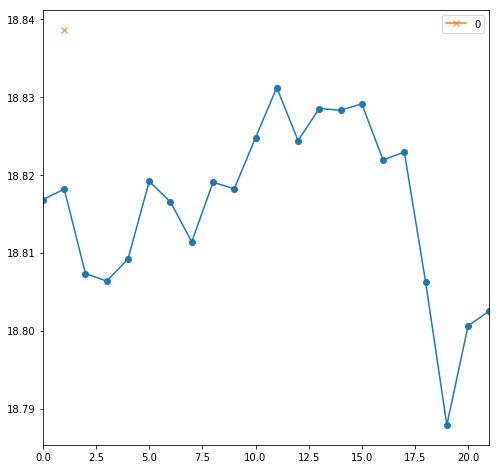

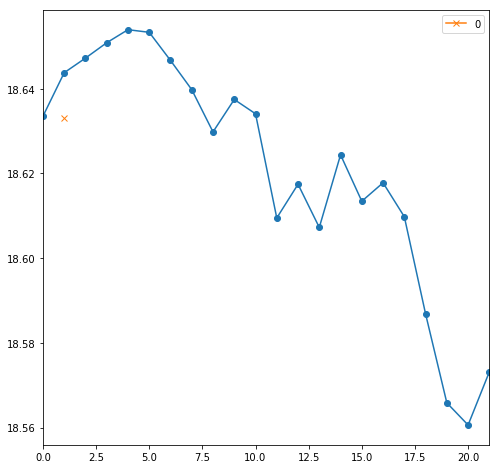

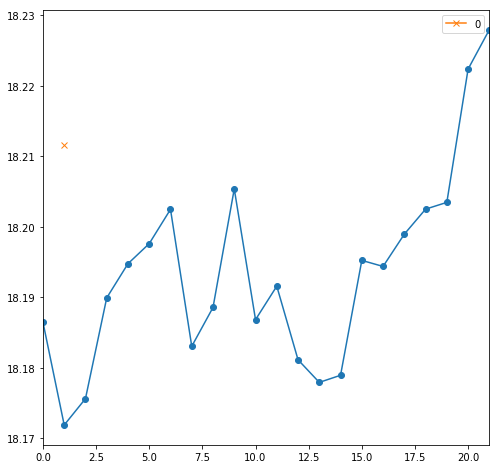

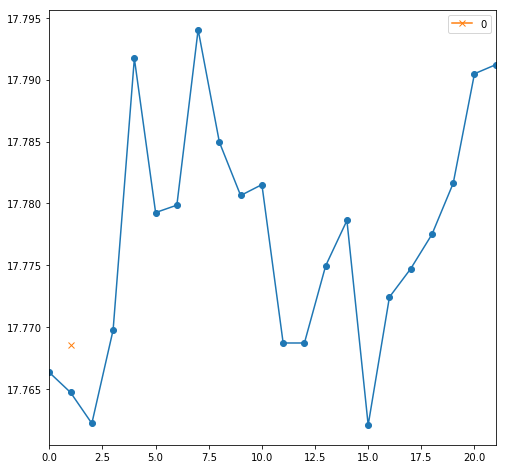

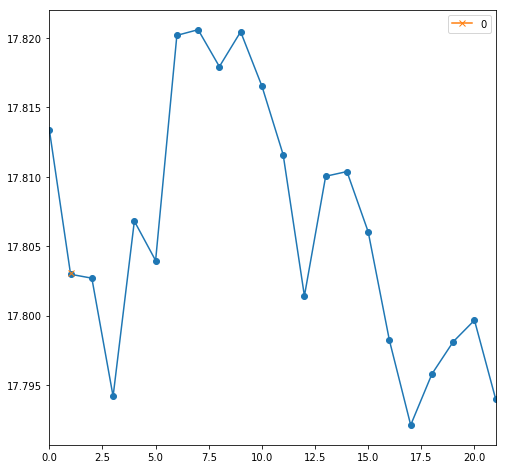

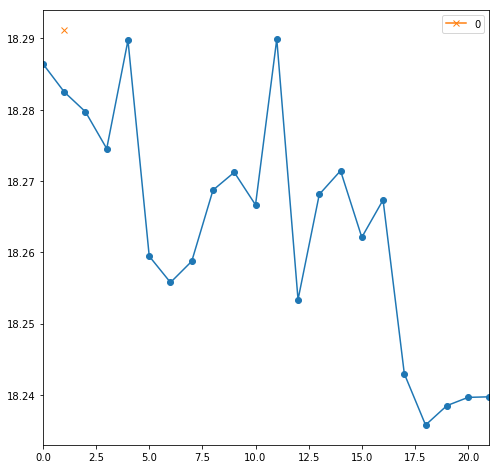

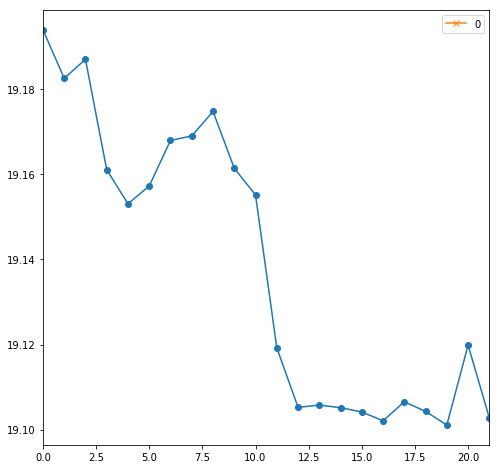

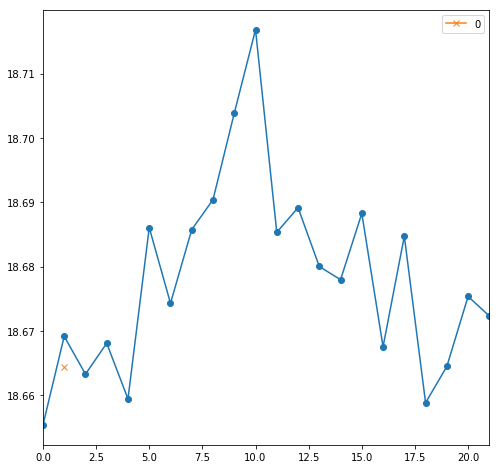

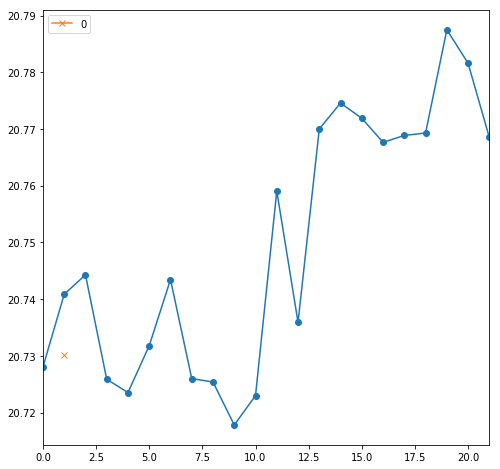

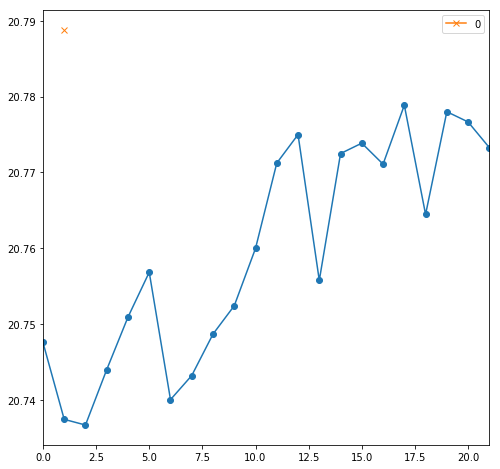

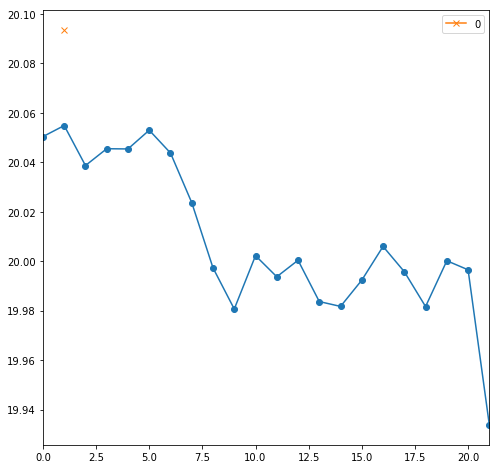

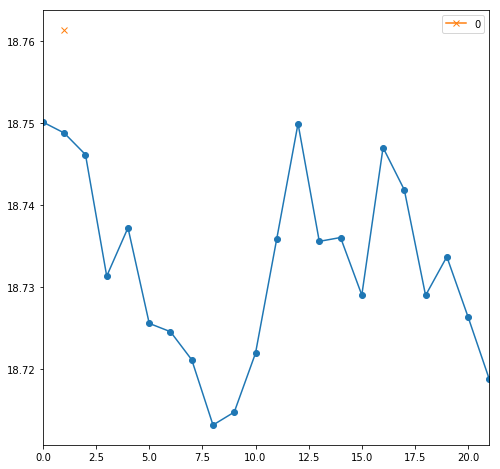

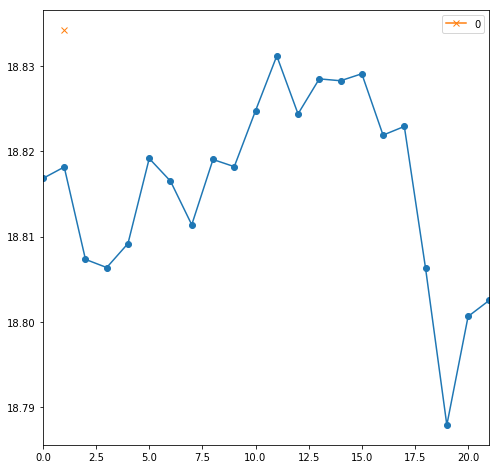

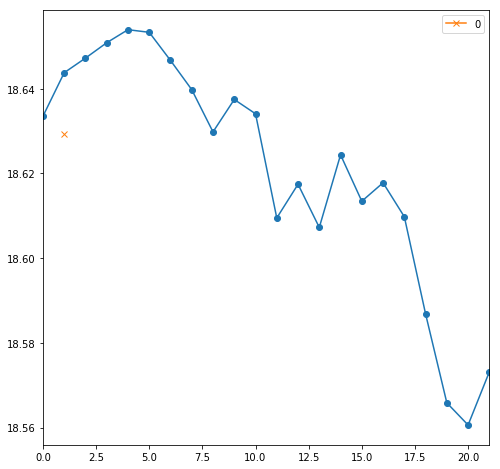

In [38]:
#La gráfica de lo históricos y donde se realizaron las compras representados por una x.

for i in range(len(res.dataframe)):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    temp[i]['Close'].plot(marker='o',x=ax)
    pd.DataFrame([precios_compras[i]],index=[res.values[0][2]]).plot(marker='x',ax=ax)
    plt.show()


### #Gráfica para visualizar la evolución del capital de la cuenta

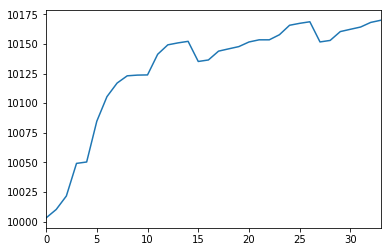

In [39]:
#Gráfica para visualizar el capital de la cuenta
trades.Total.plot()

### Gráfica con el drowdown de la cuenta

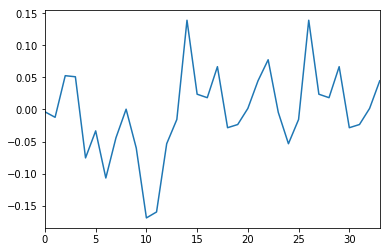

In [40]:
#Gráfica con el drowdown de la cuenta
data.c3_drawDown.plot()

### Objetivo 3 (backtest)

Se calculan las medidas de atribución al desempeño básicas

In [41]:
#Rendimiento final
trades.Total.iloc[-1]/10000-1

0.01699864900000092

In [42]:
#desviación estandar de rend diarios
np.std(((np.array(trades.Total.iloc[:-1])-np.array(trades.Total.iloc[1:]))/np.array(trades.Total.iloc[1:])))

0.0009571814606734333

### Objetivo 4(Desempeño)

Se calculan las medidas de atribución al desempeño para trading

In [43]:
#min maximo y mediana
data.c3_drawDown.min(),data.c3_drawDown.max(),data.c3_drawDown.mean()

(-0.16907999999999745, 0.13909999999999911, -0.004150000000000359)

La cuenta si termina con un rendimiento final positivo

In [44]:
#se calcula el ratio de ganancia vs drawdown y si es mayor a 1.
(trades.Total.iloc[-1]/10000-1)/(data.c3_drawDown.max())*100

12.220452192667885

## Conclusión

En conlusión se llegó a un rendimiento final positivo en la cuenta, por lo cual esto indica que es una  estrategia de trading consistente y funcional, ya que desde la obtención de los datos hasta la optimización de parámetros para realizar las compras y ventas este algoritmo nos brinda un rendimiento final positivo es decir una ganacia real en dólares. Todo esto se puede comprobar con las medidas de atribución del desempeño básicas y de trading. Aparte este algoritmo puede probar con distintos indicadores, para así poder analizar de forma más detallada y exacta los eventos a la hora de realizar trading con base al análisis fundamental de noticias, en este caso de Estados Unidos.

### Objetivo 5(tiempo real)

El tiempo real no lo alcanzaremos a terminar.